<a href="https://colab.research.google.com/github/VictorZwart/ScriptieOffensiveLanguage/blob/main/BiLSTM%26CNN/scriptie_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN Convolutional Neural Networks

Based on the following tutorial: https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9

In [2]:
# get gpu specs
!nvidia-smi
# Tesla K80 (11441MiB) = bad
# Tesla T4  (15109MiB) = good


Sat May 22 08:33:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import
First import all the necessary packages

In [3]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

#BiLstm imports:
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, Dropout, Bidirectional

# Modules for data manipulation
import numpy as np
import pandas as pd
import re
import csv

import urllib
import shutil
import sys
from sklearn.model_selection import train_test_split


# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix


import tensorflow as tf

# Dummy classifier
from sklearn.dummy import DummyClassifier


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
# upload data
from google.colab import files
train_upload = files.upload()
test_upload= files.upload()
print(test_upload)
print(train_upload)

KeyboardInterrupt: ignored

In [11]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

Import Data

In [12]:
def preprocess(line):
    # first lowercase:
    line = line.lower()

    #remove mentions:
    line = re.sub(r'(@\w+)','MENTION', line)

    #remove url's:
    line = re.sub(r'(https\S+)','URL',line)

    #remove all numbers
    line  = re.sub(r'[0-9]+', 'NUMBER', line)

    #remove all hashtags
    line  = re.sub(r'#', '', line)


    return line

input = '@arieboomsma Ik heb je 12 stukken gelezen #Indrukwekkend maar https://t.co/NQMxvgXXW6 vertel @arieboomsma dat ook even tegen de nabestaanden in #Parijs en tegen de andere slachtoffers https://t.co/NQMxvgXXW6'
print(preprocess(input))

MENTION ik heb je NUMBER stukken gelezen indrukwekkend maar URL vertel MENTION dat ook even tegen de nabestaanden in parijs en tegen de andere slachtoffers URL


In [14]:
# Function to get the data with the goal, being either 'target' or 'explicitness'
def train_data():
    full_data = []
    with open('train_final.csv', encoding='utf-8') as f:
        reader = csv.DictReader(f, delimiter='\t')
        for index, line in enumerate(reader):
            text = preprocess(line['text'])
            full_data.append([text, line['explicitness'], line["target"]])
    df_full = pd.DataFrame(full_data)    
    df_full.columns = ["text", "explicitness", "target"]
    # print(len(df_full))
    df_full = df_full[df_full.explicitness != '']
    df_full = df_full.dropna(subset=['explicitness'])
    # print(len(df_full))
    train, test = train_test_split(df_full, test_size=0.2,
                                shuffle=True,
                                    random_state=42)
    return df_full

def test_data():
    full_data = []
    with open('dev_final.csv', encoding='utf-8') as f:
        reader = csv.DictReader(f, delimiter='\t')
        for index, line in enumerate(reader):
            text = preprocess(line['text'])
            full_data.append([text, line['abusive'], line["target"]])

    df_full = pd.DataFrame(full_data)    
    df_full.columns = ["text", "explicitness", "target"]
    print(len(df_full))
    df_full = df_full[df_full.explicitness != '']
    df_full = df_full.dropna(subset=['explicitness'])
    print(len(df_full))
    return df_full

# train_exp, test_exp, df_full_exp = get_data()
train_exp = train_data()
test_exp = test_data()
df_full_exp = [train_exp, test_exp]
train_target = train_exp[train_exp.explicitness != 'NOT']
test_target = test_exp[test_exp.explicitness != 'NOT']
# train_target, test_target, df_full_target = get_data()
print(train_exp, test_exp)



547
547
                                                   text  ...      target
0     MENTION MENTION iets anders, wanneer word assc...  ...  INDIVIDUAL
1     MENTION fucking schaamteloos! je kunt de afrik...  ...       GROUP
2     mijn hemel! de elite, diegenen die onze cultuu...  ...       GROUP
3     het feit dat mensen nog steeds zwarte piet sup...  ...       GROUP
4     MENTION MENTION het is goed te zien dat grlink...  ...       OTHER
...                                                 ...  ...         ...
7759  MENTION MENTION zolang moslims zich niet uitsp...  ...       GROUP
7760  MENTION netanyahu cs kopiëren hitler op een an...  ...  INDIVIDUAL
7761  MENTION MENTION MENTION MENTION zolang moslims...  ...       GROUP
7762  MENTION er staat als je zwarte piet steunt hoo...  ...       GROUP
7763  MENTION MENTION dresscode demonstratie denhaag...  ...  INDIVIDUAL

[7764 rows x 3 columns]                                                   text explicitness      target
0    wilder

# Visualisation of the data

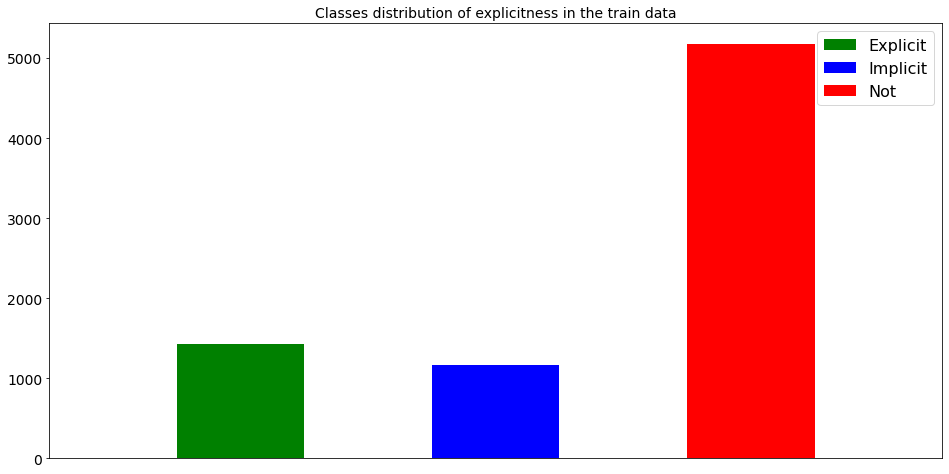

In [15]:
#plot of explicitness
plt.hist(train_exp[train_exp.explicitness == "EXPLICIT"].explicitness,
         bins=2, color='green', label='Explicit')
plt.hist(train_exp[train_exp.explicitness == "IMPLICIT"].explicitness,
         bins=2, color='blue', label='Implicit')
plt.hist(train_exp[train_exp.explicitness == "NOT"].explicitness,
         bins=2, color='red', label='Not')
plt.title('Classes distribution of explicitness in the train data')
plt.xticks([])
plt.xlim(-0.5, 3)
plt.legend()
plt.show()

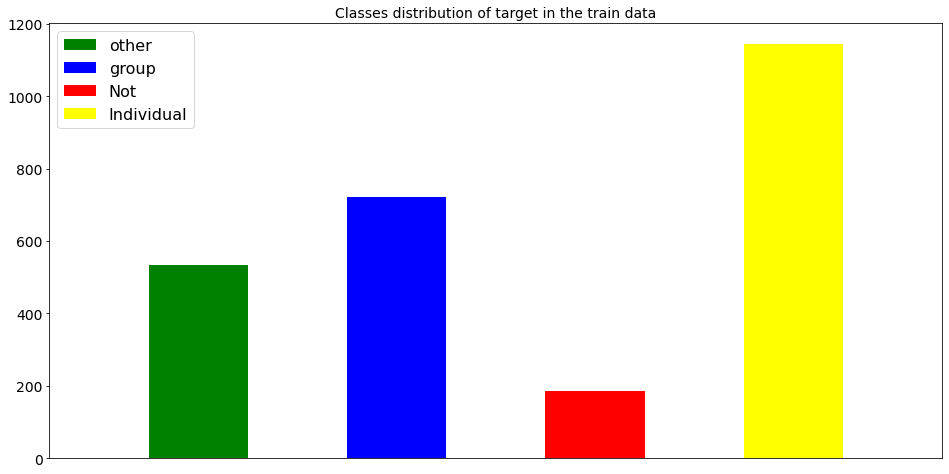

In [16]:
#plot of target
plt.hist(train_target[train_target.target == "OTHER"].target,
         bins=2, color='green', label='other')
plt.hist(train_target[train_target.target == "GROUP"].target,
         bins=2, color='blue', label='group')
plt.hist(train_target[train_target.target == "NOT"].target,
         bins=2, color='red', label='Not')
plt.hist(train_target[train_target.target == "INDIVIDUAL"].target,
         bins=2, color='yellow', label='Individual')
plt.title('Classes distribution of target in the train data')
plt.xticks([])
plt.xlim(-0.5, 4)
plt.legend()
plt.show()

In [17]:
all_reviews = np.array([], dtype=str)
df_full_exp = pd.concat(df_full_exp)
all_reviews = np.concatenate((all_reviews, df_full_exp["text"]), axis=0)
print('Total number of reviews:', len(all_reviews))
print(all_reviews)

Total number of reviews: 8311
['MENTION MENTION iets anders, wanneer word asscher voor de rechter gesleept voor het willens en wetens aan de afgrond brengen van duizende mensen door de kinderopvangtoeslagenaffaire???'
 'MENTION fucking schaamteloos! je kunt de afrikaan wel uit afrika halen...'
 'mijn hemel! de elite, diegenen die onze cultuur zouden moeten beschermen, lijden aan auto-immuumziekte ... aldus baudet nieuwsuur'
 ... 'MENTION de lafbek wil medicijnen alleen voor zijn eigen'
 'ook zonder een racist in het witte huis is amerika nog steeds een kut land vol racistische witte mensen die vinden dat het leven van een zwarte of gekleurde persoon niks waard is. en maar blijven denken dat je het meest ontwikkelde en beste land ter wereld bent.'
 'islam is gewoon een radicale beweging. altijd geweest . staat voor uitroeiing van niet moslims htler NUMBER arena']


In [18]:
print(100/len(df_full_exp)*len(df_full_exp[df_full_exp.explicitness == "NOT"]))

67.53699915774276


# Preprocessing
Start the preprocessing here

# Initiate Model and word Embeddings

In [19]:
# Word embeddings:

def demoModel(inputFile):
    # Let's not presume gensim installation until needed
    import gensim
    sys.stderr.write("Loading model...\n")
    model = gensim.models.KeyedVectors.load_word2vec_format(inputFile, binary=True)
    sys.stderr.write("Model loaded\n")

    return model

def downloadModel():
    modelUrl = "https://github.com/coosto/dutch-word-embeddings/releases/download/v1.0/model.bin"

    # Request model data
    try:
        request = urllib.request.Request(modelUrl)
        with urllib.request.urlopen(request) as response, open("/content/drive/MyDrive/Scriptie/code/Coosto", 'wb') as fp:
            shutil.copyfileobj(response, fp)
            sys.stderr.write("Model saved: {}\n".format(fp.name))
        return "/content/drive/MyDrive/Scriptie/code/Coosto"
    except urllib.error.HTTPError as error:
        sys.stderr.write("Error fetching model from github.com - {}\n".format(error))
        sys.stderr.write("{}".format(error.read()))
        exit(1)



In [20]:
model = downloadModel()

Model saved: /content/drive/MyDrive/Scriptie/code/Coosto


In [21]:
coosto_model = demoModel(model)
coosto_model.most_similar("pilsje")

Loading model...
Model loaded


[('biertje', 0.9145998954772949),
 ('glas_bier', 0.7679998874664307),
 ('wijntje', 0.7564073801040649),
 ('paar_biertjes', 0.7425606846809387),
 ('pilsjes', 0.7367861270904541),
 ('biertjes', 0.7344973087310791),
 ('colaatje', 0.7323644161224365),
 ('pilske', 0.724961519241333),
 ('borreltje', 0.7243227958679199),
 ('pils', 0.7234804630279541)]

# Build model

In [22]:
import numpy



x_train_text = train_exp["text"]
x_test_text = test_exp["text"]
y_test_text = test_exp["explicitness"]
y_train_text = train_exp["explicitness"]
print(x_train_text)

# print(y_train_data_text)
# print(y_train_data[:100])

# x_train_text, x_test_text, y_train_text, y_test_text = train_test_split(
#     all_reviews,
#     y_train_data_text,
#     test_size=0.2,
#     shuffle=True,
#     random_state=69)


# x_train, x_test, y_train, y_test = train_test_split(
#     pad_sequences(
#     sequences=vectorize_data(all_reviews, vocab=coosto_model.wv.vocab),
#     maxlen=input_length,
#     padding='post'),
#     y_train_data_text,
#     test_size=0.2,
#     shuffle=True,
#     random_state=69)

0       MENTION MENTION iets anders, wanneer word assc...
1       MENTION fucking schaamteloos! je kunt de afrik...
2       mijn hemel! de elite, diegenen die onze cultuu...
3       het feit dat mensen nog steeds zwarte piet sup...
4       MENTION MENTION het is goed te zien dat grlink...
                              ...                        
7759    MENTION MENTION zolang moslims zich niet uitsp...
7760    MENTION netanyahu cs kopiëren hitler op een an...
7761    MENTION MENTION MENTION MENTION zolang moslims...
7762    MENTION er staat als je zwarte piet steunt hoo...
7763    MENTION MENTION dresscode demonstratie denhaag...
Name: text, Length: 7764, dtype: object


In [23]:
def vectorize_data(data, vocab): # First vectorize the data
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    return vectorized

In [24]:
input_length = coosto_model.vector_size # define the input length
print('Convert sentences to sentences with ngrams...', end='\r')
print('Convert sentences to sentences with ngrams... (done)')
print('Vectorize sentences...', end='\r')
x_train = pad_sequences(
    sequences=vectorize_data(x_train_text, vocab=coosto_model.wv.vocab),
    maxlen=input_length,
    padding='post') # Use X_pad to fillup the data
x_test = pad_sequences(
    sequences=vectorize_data(x_test_text, vocab=coosto_model.wv.vocab),
    maxlen=input_length,
    padding='post') # Use X_pad to fillup the data

Convert sentences to sentences with ngrams... (done)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


In [25]:
y_test = y_test_text

y_train = y_train_text
# print(y_test)
# print(y_train)
codes, uniques = pd.factorize(pd.concat([y_test_text, y_train_text]))
y_test = codes[:len(y_test)]
y_train = codes[len(y_test):]
# print(y_test)
# print(y_train)
print(uniques)
y_test = numpy.array(y_test)
y_train = numpy.array(y_train)


print('Vectorize sentences... (done)')
print('Transform sentences to sequences... (done)')
print(y_train[5:15])
print(y_train_text[5:15]) # So 0 is NOT, 1 is explicit, 2 is implicit

Index(['NOT', 'EXPLICIT', 'IMPLICIT'], dtype='object')
Vectorize sentences... (done)
Transform sentences to sequences... (done)
[1 2 2 2 2 1 1 1 1 2]
5     EXPLICIT
6     IMPLICIT
7     IMPLICIT
8     IMPLICIT
9     IMPLICIT
10    EXPLICIT
11    EXPLICIT
12    EXPLICIT
13    EXPLICIT
14    IMPLICIT
Name: explicitness, dtype: object


In [26]:
def build_cnn_model(embedding_matrix, input_length):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Conv1D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    # model.add(Dense(1, activation='sigmoid'))
    model.summary()
    # model.add(Dense(8, input_dim=4, activation='relu'))
    # model.add(Dense(3, activation='softmax'))
	# # Compile model
    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_bilstm_model(embedding_matrix, input_length):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.summary()
    return model

In [27]:
input_length = coosto_model.vector_size

cnn_model = build_cnn_model(
    embedding_matrix=coosto_model.wv.vectors,
    input_length=input_length)

bilstm_model = build_bilstm_model(
    embedding_matrix=coosto_model.wv.vectors,
    input_length=input_length)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          75143700  
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4800)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 14403     
Total params: 75,186,935
Trainable params: 43,235
Non-trainable params: 75,143,700
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          75143700  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 75,599,639
Trainable params: 455,939
Non-trainable params: 75,143,700
____________________________________

# Fit model

In [28]:
with tf.device('/device:GPU:0'):
    bilstm_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer='adam',
        metrics=['accuracy'])

    bilstm_history = bilstm_model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_test, y_test),
        batch_size=100,
        epochs=5)

Epoch 1/5
78/78 [==============================] - 150s 2s/step - loss: 0.9126 - accuracy: 0.6465 - val_loss: 0.6581 - val_accuracy: 0.7989
Epoch 2/5
78/78 [==============================] - 141s 2s/step - loss: 0.8595 - accuracy: 0.6745 - val_loss: 0.6870 - val_accuracy: 0.7989
Epoch 3/5
78/78 [==============================] - 142s 2s/step - loss: 0.8522 - accuracy: 0.6736 - val_loss: 0.7287 - val_accuracy: 0.7989
Epoch 4/5
78/78 [==============================] - 141s 2s/step - loss: 0.8487 - accuracy: 0.6706 - val_loss: 0.6707 - val_accuracy: 0.7989
Epoch 5/5
78/78 [==============================] - 144s 2s/step - loss: 0.8466 - accuracy: 0.6704 - val_loss: 0.6799 - val_accuracy: 0.7843


In [29]:
with tf.device('/device:GPU:0'):
    cnn_model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam', 
                metrics=['accuracy'])
    cnn_model.summary()

    # Fitting the data onto model
    history = cnn_model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_test, y_test),
        batch_size=100,
        epochs=5)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          75143700  
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4800)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 14403     
Total params: 75,186,935
Trainable params: 43,235
Non-trainable params: 75,143,700
_________________________________________________________________
Epoch 1/5
78/78 [==============================] - 31s 17ms/step - loss: 0.9121 - accuracy: 0.6479 - val_

In [30]:
print(x_test)
print(x_train)
print(type(y_test))
print(y_test)
print(type(y_train))
print(y_train)

print(len(x_test), len(x_train), len(y_test), len(y_train))

print(x_test.shape, x_train.shape, y_test.shape, y_train.shape)

[[1806 1252 2228 ...    0    0    0]
 [1039 1039  385 ...    0    0    0]
 [2941  783 2217 ...    0    0    0]
 ...
 [ 579 1039 2228 ...    0    0    0]
 [ 783  783  884 ...    0    0    0]
 [1252  964 2228 ...    0    0    0]]
[[1252 1039  161 ...    0    0    0]
 [2941  105 1247 ...    0    0    0]
 [ 446 1252 2351 ...    0    0    0]
 ...
 [3113  783 2228 ...    0    0    0]
 [1039 2217  964 ...    0    0    0]
 [ 579 2217 1039 ...    0    0    0]]
<class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [31]:
# Getting score metrics from our model
bilstm_scores = bilstm_model.evaluate(x_test, y_test, verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (sum(bilstm_scores)/len(bilstm_scores)*100))

Accuracy: 73.21%


In [32]:
# Getting score metrics from our model
cnn_scores = cnn_model.evaluate(x_test, y_test, verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (sum(cnn_scores)/len(cnn_scores)*100))

Accuracy: 74.65%


# Visualisation

In [33]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [34]:
y_train_pred = cnn_model.predict_classes(x_train)
y_test_pred = cnn_model.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


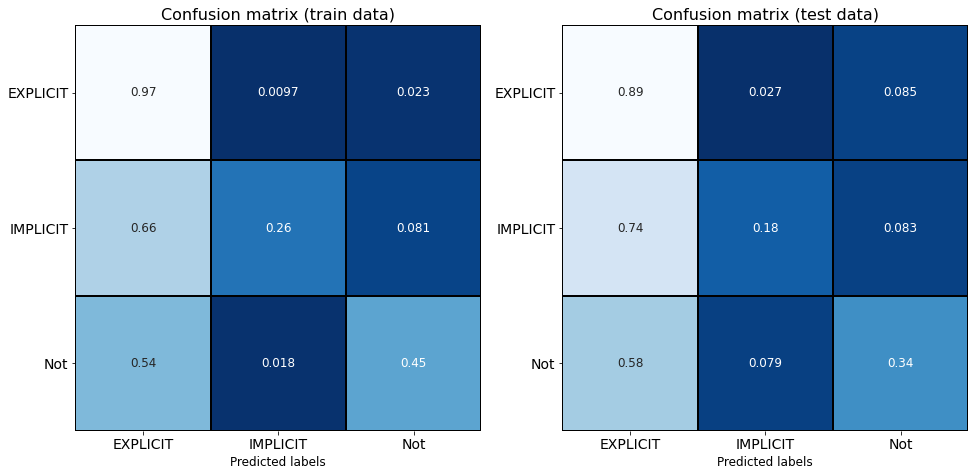

In [35]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['EXPLICIT', 'IMPLICIT', "Not"])
plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['EXPLICIT', 'IMPLICIT', "Not"])

# Wrongly classified

2 lists, zip
Before the splitting I should keep track of the data
Somewhere in the middle I lose track of the tokens.


Map the words to the word embeddings


#BiLSTM misclassified

In [42]:
wrong = {
        # 'text' => ['golden', 'bilstm', 'cnn']
}
print(wrong)

{}


In [43]:
pred = bilstm_model.predict(x_test)
rounded_pred = []
for prediction in pred:
    rounded_pred.append(prediction.argmax())
index = 0
# print(rounded_pred)

for pred, real in zip(rounded_pred, y_test):
    if pred != real:
        wrong[x_test_text[index]] = [real, pred, real, real]
    index += 1

print(bilstm) 
print(y_train[2])
print(y_train_text[2])
for text, pred in wrong.items():
    print(text, pred)
# So 0 is NOT, 1 is explicit, 2 is implicit

[1, 0, 0]
2
IMPLICIT
MENTION MENTION iets anders, wanneer word asscher voor de rechter gesleept voor het willens en wetens aan de afgrond brengen van duizende mensen door de kinderopvangtoeslagenaffaire??? [0, 2, 0, 0]
MENTION MENTION MENTION iets anders, wanneer word asscher voor de rechter gesleept voor het willens en wetens aan de afgrond brengen van duizende mensen door de kinderopvangtoeslagenaffaire??? [0, 2, 0, 0]
MENTION MENTION iedereen kan ervan leren. bijv. hoe een demagoog een volk demoniseerde en zijn partij als alleenheerser leidde. [0, 2, 0, 0]
MENTION MENTION iedereen die het niet eens is met standpunten sylvana móet volgens artikelNUMBER wel een racist/facist/vrouwenhater zijn [0, 2, 0, 0]
iedereen feliciteer MENTION even! ze is echt een super toffe meid dus NUMBER felicitaasitje kan wel😊 || rt is lieff❤ [0, 2, 0, 0]
iemand hier ervaring met body stress release-behandeling? dtv [0, 2, 0, 0]
MENTION ach man ! je hebt geen idee hoeveel er goed de pest hebben in je gedrag

#CNN misclassified

In [44]:
pred = cnn_model.predict(x_test)
rounded_pred = []
for prediction in pred:
    rounded_pred.append(prediction.argmax())
index = 0
cnn = []
for pred, real in zip(rounded_pred, y_test):
    if pred != real:
        text = x_test_text[index]
        cnn.append((text,pred,y_test[index])) # In the form (text, prediction, golden)
        if text in wrong:
            bilstm = wrong[text] 
            bilstm[2] = pred
            wrong[text] = bilstm
        else:
            wrong[text] = [real, real, pred, real]
    index += 1

for text, pred in wrong.items():
    print(text, pred)
# for prediction in pred:
#     print(prediction)
# indices = [i for i,v in enumerate(pred) if pred[i]!=y_train[i]]
# subset_of_wrongly_predicted = [x_train[i] for i in indices ]
# print(subset_of_wrongly_predicted[:100])
# print(len(subset_of_wrongly_predicted))
# # print(subset_of_wrongly_predicted)

MENTION MENTION iets anders, wanneer word asscher voor de rechter gesleept voor het willens en wetens aan de afgrond brengen van duizende mensen door de kinderopvangtoeslagenaffaire??? [0, 2, 2, 0]
MENTION MENTION MENTION iets anders, wanneer word asscher voor de rechter gesleept voor het willens en wetens aan de afgrond brengen van duizende mensen door de kinderopvangtoeslagenaffaire??? [0, 2, 2, 0]
MENTION MENTION iedereen kan ervan leren. bijv. hoe een demagoog een volk demoniseerde en zijn partij als alleenheerser leidde. [0, 2, 0, 0]
MENTION MENTION iedereen die het niet eens is met standpunten sylvana móet volgens artikelNUMBER wel een racist/facist/vrouwenhater zijn [0, 2, 0, 0]
iedereen feliciteer MENTION even! ze is echt een super toffe meid dus NUMBER felicitaasitje kan wel😊 || rt is lieff❤ [0, 2, 0, 0]
iemand hier ervaring met body stress release-behandeling? dtv [0, 2, 0, 0]
MENTION ach man ! je hebt geen idee hoeveel er goed de pest hebben in je gedrag . denk niet dat je h

In [45]:
print(wrong)
fields = ["text", "golden", 'BiLSTM', 'CNN', 'LinearSVC']
headers = {'text','golden','BiLSTM', 'CNN', 'LinearSVC' }
with open('wrong.csv', 'w') as csv_file:
    writer = csv.writer(csv_file, delimiter='\t')
    writer.writerow(fields)
    for text, pred in wrong.items():
        row = [text, pred[0], pred[1], pred[2], pred[3]]

        writer.writerow(row)
files.download('wrong.csv')    

# So 0 is NOT, 1 is explicit, 2 is implicit


{'MENTION MENTION iets anders, wanneer word asscher voor de rechter gesleept voor het willens en wetens aan de afgrond brengen van duizende mensen door de kinderopvangtoeslagenaffaire???': [0, 2, 2, 0], 'MENTION MENTION MENTION iets anders, wanneer word asscher voor de rechter gesleept voor het willens en wetens aan de afgrond brengen van duizende mensen door de kinderopvangtoeslagenaffaire???': [0, 2, 2, 0], 'MENTION MENTION iedereen kan ervan leren. bijv. hoe een demagoog een volk demoniseerde en zijn partij als alleenheerser leidde.': [0, 2, 0, 0], 'MENTION MENTION iedereen die het niet eens is met standpunten sylvana móet volgens artikelNUMBER wel een racist/facist/vrouwenhater zijn': [0, 2, 0, 0], 'iedereen feliciteer MENTION even! ze is echt een super toffe meid dus NUMBER felicitaasitje kan wel😊 || rt is lieff❤': [0, 2, 0, 0], 'iemand hier ervaring met body stress release-behandeling? dtv': [0, 2, 0, 0], 'MENTION ach man ! je hebt geen idee hoeveel er goed de pest hebben in je g

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>